<h2>First Layer Filters of AlexNet</h2>
The first stage of AlexNet is the convolution of the 224X224X3 image with 96 11X11X3 kernels, the rest of the network solely acts on the output of these filters. It is of interest if there is any simple structure in the weights of these learned filters and if that structure ends up approximating responses we see in the nervous system.

Lets start by visualizing the filters in the first layer. Luckily these filters only have 3 channels, thus we can see all channels at once, and these channels correspond to R, G, and B so we are actually seeing what these filters will respond best to in an image. 
Below I'll set up some preliminaries.

In [62]:
import pickle
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline  
top_dir = os.getcwd().split('ipython_nb')[0]
sys.path.append(top_dir + 'xarray')
top_dir = top_dir+ 'net_code/'
sys.path.append(top_dir)
sys.path.append(top_dir + 'common')
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import d_img_process as di
import d_misc as dm


import itertools
flatten_iter = itertools.chain.from_iterable
def factors(n):
    return set(flatten_iter((i, n//i) 
                for i in range(1, int(n**0.5)+1) if n % i == 0))
goforit=True       
if 'a' not in locals() or goforit:
    with open(top_dir + 'nets/netwts.p', 'rb') as f:    
        try:
            a = pickle.load(f, encoding='latin1')
        except:
            a = pickle.load(f)


def vis_square(ax, data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    ax.imshow(data, interpolation='nearest'); ax.axis('off')

First layer weight dims:(96, 3, 11, 11)


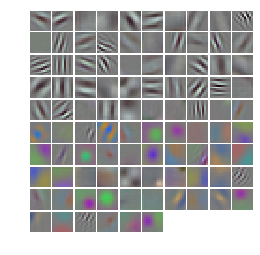

In [94]:
ax = plt.subplot(111)
wts = np.transpose(a[0][1], (0,2,3,1))
print('First layer weight dims:' + str(a[0][1].shape))
vis_square(ax, wts)

Figure 1.
Here we plot the 1st layer filters with the range across filters set to their max range, thus filters with lower contrast correspond to filters with less variance than the others. 

**Observation: The The top 48 filters seem largely black and white, and the bottom tend to be more colorful.**

<h3>Chromaticity Index</h3>
Lets make that observation quantitative by making a chromaticity index, where we will ask what fraction of the power of the $n$ channels in a given filter:
$$\vec{x}_i = \left[
\begin{array}{ccc}
R  \\
G \\
B 
\end{array}
\right]$$
cannot be explained by:
$$\vec{\bar{x}} = \frac{1}{3}(R+G+B)  \left[
\begin{array}{ccc}
1  \\
1 \\
1 
\end{array}
\right]$$

A vector consisting of the average of the R G B entries in a channel

Thus our chromaticity index $c$ will be:
$$c = \frac{\sum_i^3{(\vec{x}_i - \frac{1}{3}\sum_i^3{\vec{x}_i})^2}}{\sum_i^3{\vec{x}_i}^2}$$

or in other words the sample variance of each channel divided by the total power in all channels. Thus an index of one would imply across channels a mean of 0, and an index of 1 would imply across channels there was no variance.

Greg's advice: make this clearer with pictures.
Why note convert to LMS: because these were all taken with different cameras and so we can't have lms space.

In [64]:
def chrom_index(im):
    im_power = np.sum(im**2)
    im_var = np.sum((im - np.mean(im, -1, keepdims=True))**2)
    return im_var/im_power
wts = np.transpose(a[0][1], (0,2,3,1))
c = [chrom_index(im) for im in wts]

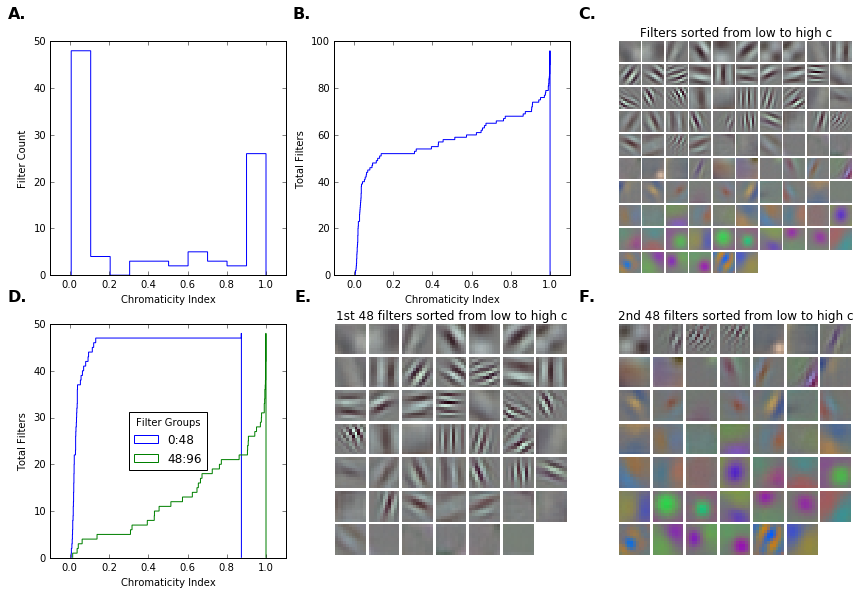

In [65]:
plt.figure()
fig, axs = plt.subplots(figsize=(12, 8), nrows=2, ncols=3)
axs = axs.ravel()
labels = ['A.', 'B.', 'C.', 'D.', 'E.', 'F.']
for ax, label in zip(axs, labels):
    _=ax.text(-0.1, 1.15, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

_=axs[0].hist(c, histtype='step',bins=10);
axs[0].set_xlabel('Chromaticity Index');
axs[0].set_ylabel('Filter Count');
axs[0].set_xlim(-0.1,1.1);

_=axs[1].hist(c, histtype='step',bins=1000, cumulative=True);
axs[1].set_xlabel('Chromaticity Index')
axs[1].set_ylabel('Total Filters')
axs[1].set_xlim(-0.1,1.1)

sort_chrom = np.array([wts[c_ind] for c_ind in np.argsort(c)])
vis_square(axs[2], sort_chrom)
axs[2].set_title('Filters sorted from low to high c')

axs[3].hist(c[:48],1000, histtype='step', cumulative=True)
axs[3].hist(c[48:],1000, histtype='step', cumulative=True)
axs[3].set_xlim(-0.1,1.1);
axs[3].set_xlabel('Chromaticity Index');
axs[3].set_ylabel('Total Filters');
axs[3].legend(['0:48', '48:96'], loc='center', title='Filter Groups')

sort_chrom1 = np.array([wts[:48][c_ind] for c_ind in np.argsort(c[:48])])
sort_chrom2 = np.array([wts[48:][c_ind] for c_ind in np.argsort(c[48:])])
grouped_sort = np.concatenate([sort_chrom1, sort_chrom2], 0)
vis_square(axs[4], sort_chrom1)
axs[4].set_title('1st 48 filters sorted from low to high c')
plt.tight_layout()

_ = vis_square(axs[5], sort_chrom2)
axs[5].set_title('2nd 48 filters sorted from low to high c')

**Figure 2**

**A** the histogram of Chromaticity values for our filters is clearly bi-modal. With roughly 25 filters nearly purely chromatic, and 48 luminant. 

**B** Examining the cumulative histogram in panel B we note sharp inflections at both ends of chromaticity, with maybe 25 or so filters resting somewhere in between. 

**C** Sorting the filters according to their chromaticity index, then replotting the filters qualitatively substantiates the index. We see the large group of black and white filters towards the top, followed by some mixed filters, and the a group of ~20 or so that primarily vary in chroma. It becomes qualitatively clearer that the chromatic filters also tend to to not reach as high of spatial frequencies as the luminance filters.

As can be guessed from observations in Figure 1, the bi-modality of the distribution of chromaticity derives from the filters in the 1st and last 48 filters. This division corresponds to a grouping parameter in the networks architecture which seperates the 1st and last 48 filters of the 1st layers outputs(to be discussed further below). We continue our analysis along this architectural division but keep in mind no weights were chosen by hand, these results are purely an interaction of architecture, training, and natural images.

**D** looking at the cumulative histograms of these two groups, in blue we see all but one have a chromaticity index less than .2, and in green there is a broader distribution but the median is well above 0.5 chromaticity, and there is clearly a sharp peak where 18 or so filters are purely chromatic. Thus the filters with middling chromaticity largely came from the 2nd filter group.

**E , F** In Panel E and F we sort the 1st and second groups respectively as we did for Panel C. In Panel F Qualitatively we see roughly half look mixed, and the rest purely chromatic, with maybe several luminance filter.

**Conclusion: There tend to be two types of filters: achromatic and chromatic, these filters also happen to largely be respectively divided into the 1st and 2nd 48 filters.**

Gregs advice: do a permutation test for the chromatic histogram, I might have trouble saying there are two clusters.

**Split in network architecture could explain difference between 1st and 2nd 48 filters**

If we examine the dimensions of the first layer we note it has 96 filters (1st entry), but the input of the second layer (second entry) has 48 input channels. The network was constructed so that filters 1:48, and 49:96 from the 1st layer are respectively input channels to filters 1:128, and 129:256 in the second layer. 

Back propagation is performed with respect these grouped inputs, thus I would hypothesise this qualitative difference between the 1st and last 48 is a result of training with the grouping parameter. Filters co-adapt to luminance features in one group, and in the other largely to chromatic features. This might be akin to a grouping meta parameter in regularized regression.

<h3>Visualizing Filters in RGB space</h3>

Filters with a low chromaticity vary essentially in only 1-dimension in RGB space along the vector of ones, I'll call this variation in luminance. The variation left to chromaticity is in 2-dimensions I'll call this the chromatic plane.  Lets view our kernels in this 2-d chroma space to see if there is anymore clear structure to observe.


ValueError: diag requires an array of at least two dimensions

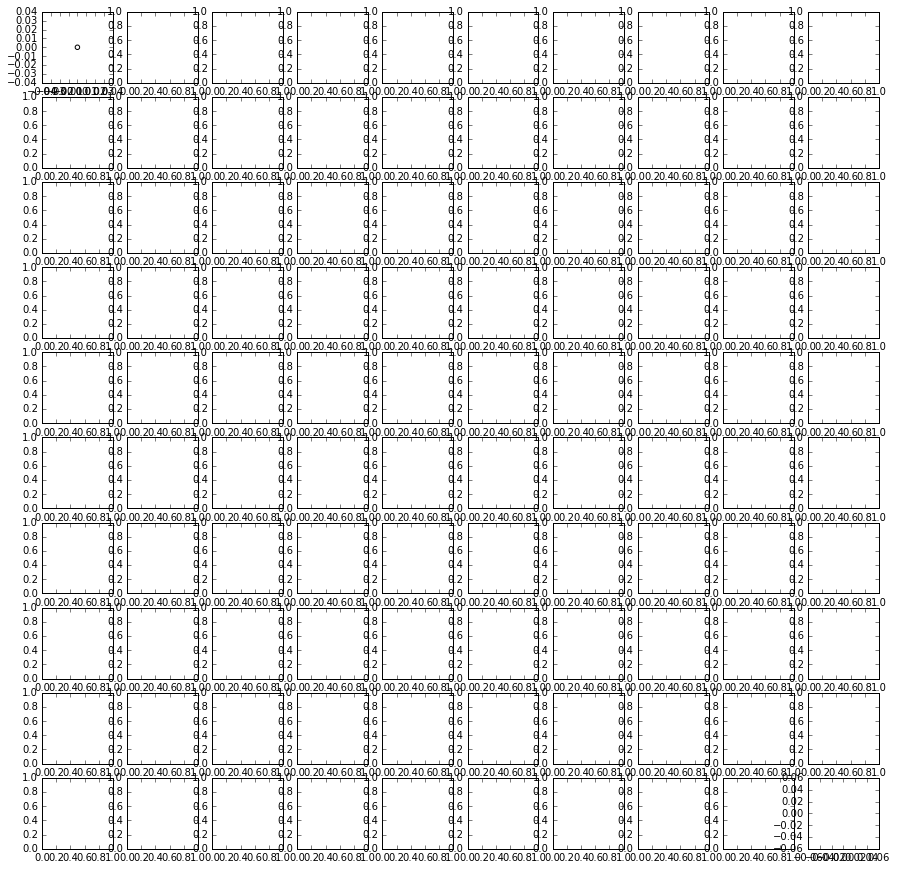

In [90]:
wts = np.transpose(a[0][1], (0,2,3,1))
c = np.array([chrom_index(im) for im in wts])
wts_c = wts - np.mean(wts, -1,keepdims=True)
#our reference points for plotting in the 2-d space
rgb = np.eye(3) 
axis1 = np.real(np.fft.ifft([0,1,0]))#easy way to get two  3-vectors orthogal to each other and the mean
axis2 = np.imag(np.fft.fft([0,1,0]))
proj_mat = np.vstack([axis1 ,axis2]).T
proj_mat /= np.sum(proj_mat**2, 0, keepdims=True)**0.5
rgb_proj = np.dot(rgb, proj_mat)

fig, axs = plt.subplots(figsize=(15,15), nrows=10, ncols=10)
for ax, c_ind in zip(axs.ravel(), np.argsort(c)[::-1][:20]):
    to_proj = wts[c_ind].squeeze()
    to_proj = to_proj.reshape(np.product(to_proj.shape[:-1]), 3)
    to_proj = to_proj - np.expand_dims(to_proj.mean(1), 1)
    to_proj = to_proj / np.max(np.sum(to_proj**2, 1)**0.5)
    proj = np.dot(to_proj, proj_mat)
    
    color = np.array(to_proj - np.min(to_proj))
    color /= np.max(color)
    #_=ax.scatter(proj[:, 1], proj[:, 0], c=color, linewidths=0)
    _=ax.scatter(0, 0, c='none', linewidths=1);_=plt.axis('equal')
    
    u, s, v = np.linalg.svd(to_proj, full_matrices=False)
    first_pc_c = v[:, 0]
    reco = np.dot(np.dot(u[0w, :], s[0]), first_pc_c)
    proj = np.dot(reco, proj_mat)
    _=ax.scatter(proj[:,0], proj[:, 1], c=color, linewidths=0)

    #proj_pc = np.dot(first_pc_c, proj_mat)
    #ax.scatter(proj_pc[0], proj_pc[1], color='k')  

    
    
    #ax.set_title('i='+str(c_ind) +' \nc='+ str(np.round(c[c_ind],2)) +
    #             '\n amp=' + str(np.round(amp,2)), fontsize=6)
    #for spine in ['left', 'right', 'bottom', 'top']:
    #    ax.spines[spine].set_visible(False)
    #_=ax.scatter(rgb_proj[:,0], rgb_proj[:,1], c=rgb, linewidths=1)
for ax in axs.ravel():
    ax.set_xticks([]);ax.set_yticks([]);ax.axis('equal')

2nd filter group plotted in [R, G, B] perp to [1,1,1] plane


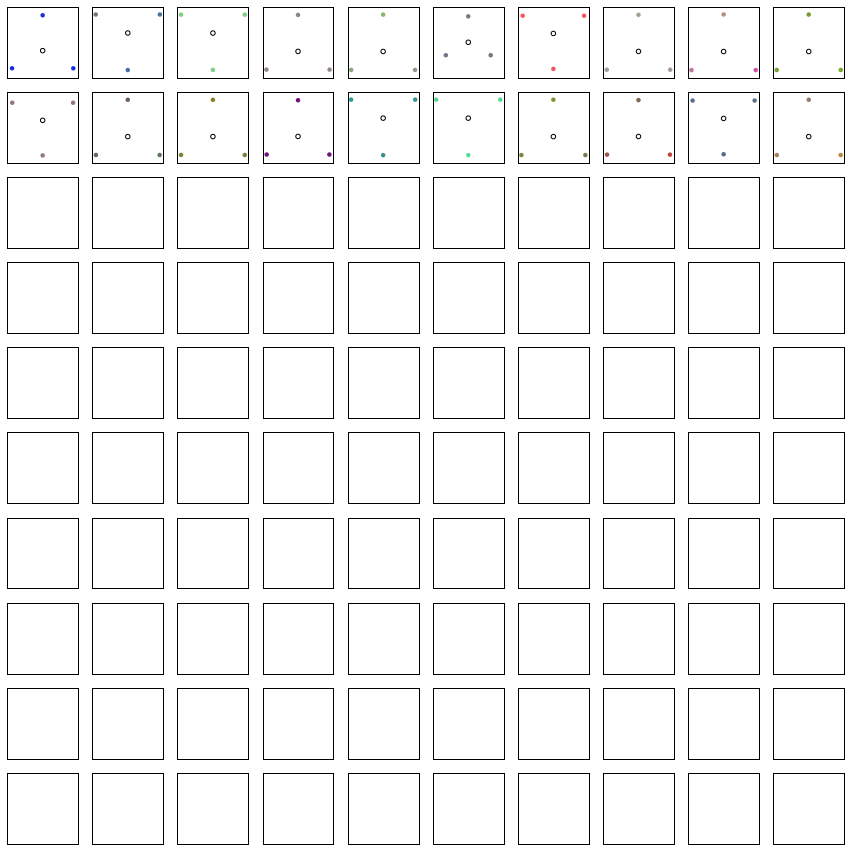

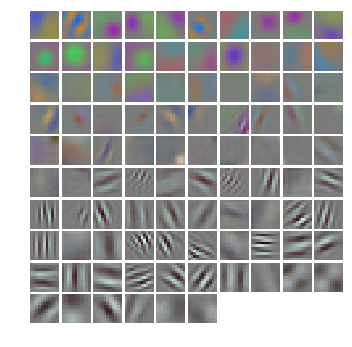

In [80]:
   
print('2nd filter group plotted in [R, G, B] perp to [1,1,1] plane')
fig, ax = plt.subplots(figsize=(5, 5), nrows=1, ncols=1)
vis_square(ax, wts[np.argsort(c)[::-1][:len(axs.ravel())]])
plt.savefig('/Users/deanpospisil/Desktop/filters.pdf')

plt.tight_layout()

In [84]:
print(np.shape(proj))
print(np.shape(first_pc_c))
print(np.shape(to_proj))
print(np.shape(proj_pc))
print(np.shape(v))
print(proj)
print(v.shape)
print(u.shape)
print(s.shape)

(3, 2)
(3,)
(121, 3)
(2,)
(3, 3)
[[ 0.26982769  0.        ]
 [-0.13491385 -0.23367764]
 [-0.13491385  0.23367764]]
(3, 3)
(121, 3)
(3,)


**Figure 3.** 
To give a sense of scale each of these scatter is divided by the magnitude of the channel with the greatest magnitude. And since these are projected onto the chroma plane, if the scatter is very small it then means there was at least one kernel with alot of magnitude in the luminance direction.
For reference on each plot are an outlined red, green, blue, and white dot. The red, green, and blue correspond respectively to the directions [1,0,0], [0, 1, 0], and [0, 0, 1] projected on the chromatic plane. The white dot is the origin.

An initial striking observation is that the purely chromatic filters tend to vary in only one dimension and cross the origin. I would take this as evidence that these color filters are *'color-opponent'*.

**Conclusion: High chroma filters tend to be color opponent and by defintion low chroma filters tend to be luminance filter**

Gregs advice: these are linear in chroma, and they change signs so they are opponent.

<h3>Orientation in Chroma Plane</h3>
It would seem that there are some preferences in the chroma plane, lets make a polar plot of orientation preference. To do this we will get the first principal component in RGB space for a filter, then we will project that vector onto the chroma axis (subtract out its mean), then choose two arbitrary orthogonal axes in that plane to get their angle based on their ratio with respect to these two. Then collect all those angles and make a polar histogram, maybe have angles sorted by chroma, so you don't get a bunch of noise from luminance filters.

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.48286396,  0.74269194,  1.00251993,  1.26234792,  1.5221759 ,
         1.78200389,  2.04183188,  2.30165986,  2.56148785,  2.82131584,
         3.08114382]),
 <a list of 10 Patch objects>)

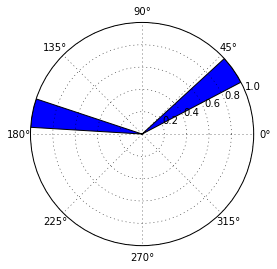

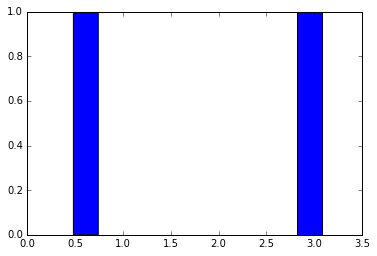

In [32]:
chroma_angles = []
for filt in wts_c[c.argsort()[::-1]][:2]:
    to_proj = filt.reshape(np.product(filt.shape[:-1]), 3)
    u, s, v = np.linalg.svd(to_proj, full_matrices=False)
    first_pc_c = v[:, 0]
    #first_pc_c = first_pc - np.mean(first_pc)#project onto chroma
    proj = np.dot(first_pc_c, proj_mat)
    c_num = proj[0] + 1j*proj[1]
    if np.angle(c_num)<0:
        c_num = -c_num
    chroma_angles.append(np.angle(c_num))
n_bins = 10
hist, bins = np.histogram(chroma_angles, bins=n_bins)
ax = plt.subplot(111, projection='polar')
width = bins[1]-bins[0]
bars = ax.bar(bins[:-1], hist, width=width ,bottom=0.0, )
plt.figure()
plt.hist(chroma_angles, bins=n_bins)

In [30]:
print(proj.shape)
print(first_pc_c.shape)
print(proj_mat.shape)

(2,)
(3,)
(3, 2)


In [14]:
N= 20
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = 10 * np.random.rand(N)
width = np.pi / 4 * np.random.rand(N)

ax = plt.subplot(111, projection='polar')
bars = ax.bar(theta, radii, width=width, bottom=0.0)

print(u.shape)
print(s.shape)
print(v.shape)

    

(121, 3)
(3,)
(3, 3)


<h3>Chromaticity and Spatial Frequency</h3>

One other noticeable difference among the filters is their different spatial frequency preferences. Upon examination it would appear the chromatic are lower frequency than the luminant. To quantify this observation I will perform the fourier transform of the filters reconstructed by the 1st principal component for the channels (in others words the direction it varies most in RGB space). I will then choose the frequency index of the max fourier coefficient as the peak frequency. 

In [9]:
c = np.array([chrom_index(im) for im in wts])
val_map = []
for a_filter in wts:
    a_filter_unwrap = a_filter.reshape(np.product(a_filter.shape[:-1]),3)
    u,s, v = np.linalg.svd(a_filter_unwrap, full_matrices=False)
    val_map.append(np.dot(a_filter_unwrap, v[0,:]).reshape(np.shape(a_filter)[:-1]))
val_map = np.array(val_map)
ft_val_map = np.abs(np.fft.fft2(val_map))

ft_val_map = np.array([np.fft.fftshift(a_map) for a_map in ft_val_map])
index = np.linspace(-1,1,11)
x, y = np.meshgrid(index,index)
y = np.abs(y)#complex conjugate
freq = (x**2 + y**2)**0.5
orientation = np.angle(x+y*1j)

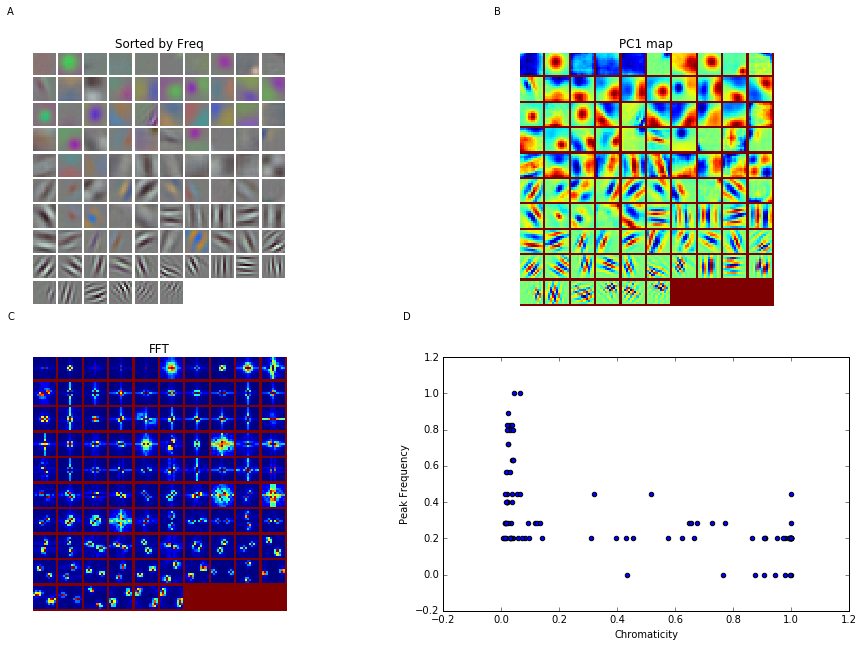

In [10]:
top_freq = np.array([freq.ravel()[a_map.ravel().argmax()] for a_map in ft_val_map])
plt.figure(figsize=(16,10))
ax = plt.subplot(224)
ax.scatter(c, top_freq)
ax.set_xlabel('Chromaticity')
ax.set_ylabel('Peak Frequency')
_=ax.text(-0.1, 1.15, 'D', transform=ax.transAxes)

ax = plt.subplot(221)
sort_freq = np.array([wts[freq_ind] for freq_ind in np.argsort(top_freq)])
vis_square(ax, sort_freq)
ax.set_title('Sorted by Freq')
_=ax.text(-0.1, 1.15, 'A', transform=ax.transAxes)


ax = plt.subplot(222)
sort_freq = np.array([val_map[freq_ind]/np.abs(val_map[freq_ind]).max() for freq_ind in np.argsort(top_freq)])
vis_square(ax, sort_freq)
ax.set_title('PC1 map')
_=ax.text(-0.1, 1.15, 'B', transform=ax.transAxes)


ax = plt.subplot(223)
sort_freq = np.array([ft_val_map[freq_ind]/np.abs(ft_val_map[freq_ind]).max() for freq_ind in np.argsort(top_freq)])
vis_square(ax, sort_freq)
ax.set_title('FFT')
_=ax.text(-0.1, 1.15, 'C', transform=ax.transAxes)


Figure X)  

**A** The filters sorted by their chromaticity.

**B** The filters reconstructed by the first PC of across channels.

**C** Absolute Value of the Fourier transform of the PC reconstructed filters.

**D** Plot of the absolute value of the frequency index of the max fourier coefficient of the reconstructed filters, plottted against the chromaticity index of the entire filter.

**Conclusion: Chromatic filters tend to have lower peak spatial frequencies.**